In [2]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
%load_ext tensorboard
import tensorboard
tensorboard.__version__
from datetime import datetime


# Specify each path

In [3]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [4]:
NUM_CLASSES = 26

# Dataset reading

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [154]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [155]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_8 (Dropout)         (None, 42)                0         
                                                                 
 dense_14 (Dense)            (None, 20)                860       
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_15 (Dense)            (None, 10)                210       
                                                                 
 dense_16 (Dense)            (None, 26)                286       
                                                                 
Total params: 1,356
Trainable params: 1,356
Non-trainable params: 0
_________________________________________________________________


In [156]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [157]:
# Model compilation
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [158]:
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Model training

In [159]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback,tensorboard_callback]
)

Epoch 1/1000
117/128 [==========================>...] - ETA: 0s - loss: 3.1686 - accuracy: 0.0982
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
128/128 [==============================] - 1s 6ms/step - loss: 3.1587 - accuracy: 0.1015 - val_loss: 3.0142 - val_accuracy: 0.1344
Epoch 2/1000
121/128 [===========================>..] - ETA: 0s - loss: 2.9343 - accuracy: 0.1518
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
128/128 [==============================] - 1s 5ms/step - loss: 2.9289 - accuracy: 0.1530 - val_loss: 2.7256 - val_accuracy: 0.2202
Epoch 3/1000
119/128 [==========================>...] - ETA: 0s - loss: 2.7260 - accuracy: 0.1888
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
128/128 [==============================] - 1s 4ms/step - loss: 2.7204 - accuracy: 0.1891 - val_loss: 2.4421 - val_accuracy: 0.3368
Epoch 4/1000
126/128 [============================>.] - ETA: 0s - loss: 2.5325 - accu

In [160]:
%tensorboard --logdir logs


Reusing TensorBoard on port 6006 (pid 15540), started 1 day, 10:29:04 ago. (Use '!kill 15540' to kill it.)

In [161]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

43/43 [==============================] - 0s 2ms/step - loss: 0.9577 - accuracy: 0.7155


In [162]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [163]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 44ms/step
[7.8969397e-02 2.4956453e-05 3.5007350e-04 9.8477809e-05 9.6939271e-03
 1.0718928e-03 1.6129363e-05 2.2238024e-05 2.1261545e-02 6.7006898e-09
 4.4350567e-05 7.3899326e-05 5.9373267e-02 3.9700128e-02 6.9689755e-03
 3.1362704e-04 5.4964994e-07 9.5795498e-05 2.9510593e-01 4.6168435e-01
 2.8443030e-05 8.1236874e-05 1.8720053e-06 1.8178852e-02 6.8400842e-03
 1.7885852e-09]
19


# Confusion matrix

170/170 [==============================] - 0s 769us/step


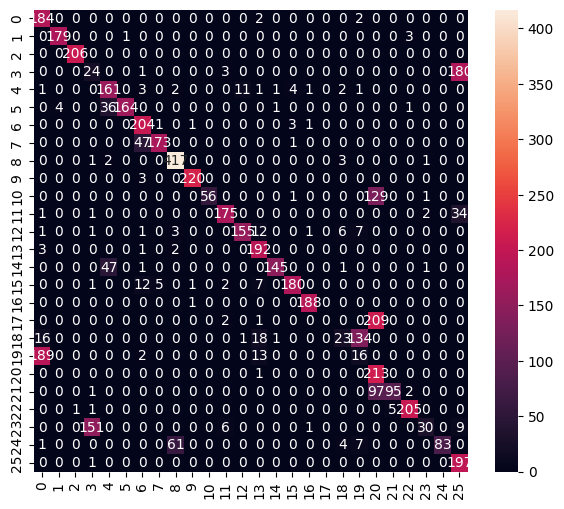

Classification Report
              precision    recall  f1-score   support

           0       0.46      0.98      0.63       188
           1       0.98      0.98      0.98       183
           2       1.00      1.00      1.00       206
           3       0.13      0.12      0.12       208
           4       0.65      0.86      0.74       188
           5       0.99      0.80      0.88       206
           6       0.74      0.97      0.84       210
           7       0.97      0.78      0.86       221
           8       0.86      0.98      0.92       424
           9       0.99      0.99      0.99       223
          10       1.00      0.30      0.46       187
          11       0.93      0.82      0.87       213
          12       0.93      0.83      0.88       187
          13       0.78      0.97      0.86       198
          14       0.98      0.74      0.85       195
          15       0.95      0.87      0.91       208
          16       0.98      0.99      0.99       189
     

c:\Users\bigdipper\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bigdipper\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bigdipper\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [164]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [165]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [166]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\BIGDIP~1\AppData\Local\Temp\tmpd4y_i9ox\assets


INFO:tensorflow:Assets written to: C:\Users\BIGDIP~1\AppData\Local\Temp\tmpd4y_i9ox\assets


7576

# Inference test

In [167]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [168]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [169]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [170]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 999 µs


In [171]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.9455078e-02 2.4950370e-05 3.5107904e-04 9.8540229e-05 9.6667744e-03
 1.0746260e-03 1.6198444e-05 2.2359995e-05 2.1452686e-02 6.7505814e-09
 4.4839668e-05 7.5006945e-05 5.9300613e-02 4.0131126e-02 6.9732298e-03
 3.1685404e-04 5.4754486e-07 9.6611613e-05 2.9444149e-01 4.6131048e-01
 2.8734032e-05 8.1443570e-05 1.8659923e-06 1.8138304e-02 6.8965983e-03
 1.8101735e-09]
19


In [172]:
!tensorflowjs_converter --input_format=keras ./model/keypoint_classifier/keypoint_classifier.hdf5 ./model/tfjs_model